In [1]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 

if SLURM_PATH in os.getcwd():
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [2]:
# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F

# Project imports #

import utils
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset
from utils import CACHE_DIR
from utils import log_response
# sys.path.append('./Mind2Web/src')

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
model.eval();

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['decoder.embed_tokens', 'encoder.embed_tokens']
  warnings.warn(


In [4]:
utils.reload('mind2web.dataloader')
idx_split_map = {0:"test_task", 1:"test_domain", 2:"test_website"}
split_idx_map = {v:k for k,v in idx_split_map.items()}

ds_dict = build_datasets_dict(idx_split_map.values(),cache_dir=CACHE_DIR);


mind2web.dataloader- reloaded


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [31]:
cal_dict, test_dict = {}, {}
seed = 42
frac = 0.1
num_candidates=5
max_context_len=512

for split, ds in ds_dict.items():
    flattened = ds_dict[split]
    cal_set, test_set = subsample_by_annotation(flattened, frac=frac, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len
    )
    test_dict[split] = MultiChoiceDataset(
        test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len
    )

In [6]:
# cal_df = utils.llm.run_evaluation(cal_dict, model, tokenizer)
# cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results.pkl")
test_df = pd.read_pickle("test_results.pkl")
# cal_df.head()

cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)



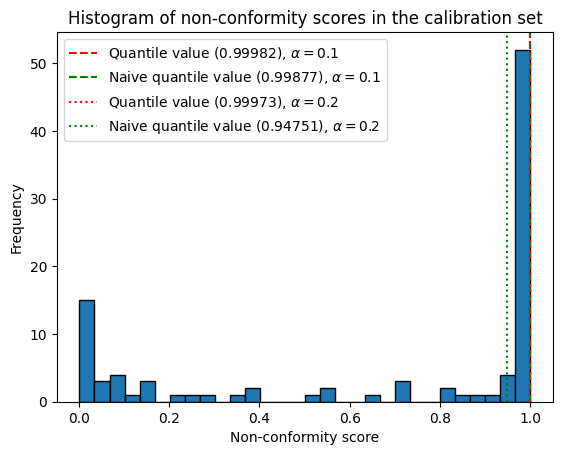

A good predictor should have low non-conformity scores, concentrated at the left side of the figure
Split: 0 - Threshold: 0.9999, Naive Threshold: 0.9093
Split: 1 - Threshold: 0.9998, Naive Threshold: 0.9991
Split: 2 - Threshold: 0.9999, Naive Threshold: 0.9988


In [7]:
def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold

# google's nonconformity score
cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)

naive_threshold = get_threshold(1 - cal_df['true_prob'], alpha=0.1)
naive_threshold2 = get_threshold(1 - cal_df['true_prob'], alpha=0.2)
threshold2 = get_threshold(score_per_group, alpha=0.2)

# plot histogram of non-conformity scores in the calibration set
utils.plot.nonconformity_histogram(
    score_per_group, threshold, naive_threshold, threshold2, naive_threshold2
)

cal_grouped_test_split = cal_df.groupby('test_split')
for split_name, group in cal_grouped_test_split:
    score_per_group = 1 - group.groupby('annotation_id')['true_prob'].min()
    threshold = get_threshold(score_per_group, alpha=0.1)
    naive_threshold = get_threshold(1 - group['true_prob'], alpha=0.1)
    print(f"Split: {split_name} - Threshold: {threshold:.4f}, Naive Threshold: {naive_threshold:.4f}")


In [8]:
# Model is probably biased towards A when not certain
print(cal_df[cal_df['correct'] == False]['pred_label'].value_counts())
# utils.plot.accuracy_vs_length(cal_df);

pred_label
A    162
D      5
B      2
F      1
E      1
Name: count, dtype: int64


In [9]:
test_df['correct'] = test_df['pred_label'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
test_task_group = test_df.groupby('annotation_id')

In [10]:
import utils.metrics
def print_evaluation(df):
    for idx_split, split_name in idx_split_map.items():
        print(f"Metrics for split: {split_name}")
        print(utils.metrics.compute_mind2web_metrics(df, split_value=idx_split))
    print(f"Metrics for overall dataset:")
    print(utils.metrics.compute_mind2web_metrics(df))

df_all = pd.concat([cal_df, test_df], ignore_index=True)
print_evaluation(df_all)

Metrics for split: test_task
{'Ele. Acc': np.float64(82.46), 'Op. F1': np.float64(79.57), 'Step SR': np.float64(76.16), 'SR': np.float64(22.6)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(72.82), 'Op. F1': np.float64(70.27), 'Step SR': np.float64(67.07), 'SR': np.float64(16.57)}
Metrics for split: test_website
{'Ele. Acc': np.float64(69.5), 'Op. F1': np.float64(67.01), 'Step SR': np.float64(62.39), 'SR': np.float64(8.45)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(74.04), 'Op. F1': np.float64(71.44), 'Step SR': np.float64(68.0), 'SR': np.float64(16.49)}


In [11]:
# print("Evaluation on Test Set")
# print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
# print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
# utils.plot.accuracy_vs_length(test_df);


In [14]:
import gc
try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del model
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del oracle
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

In [77]:
import gc
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

In [ ]:
from tqdm.auto import tqdm
def ask_oracle(df:pd.DataFrame):
    answers = []
    # iterrows is SLOW! should replace
    for i, target in tqdm(df.iterrows(), desc="Asking oracle..."):
        test_set = test_dict[idx_split_map[target['test_split']]]

        html_context, seq_in, seq_out, prev_actions, choices_str = test_set.prompt_view[target['relative_idx']]
        task = test_set.data[target['relative_idx']]['confirmed_task']
        screenshot = test_set.data[target['relative_idx']]['screenshot']
        
        answer=oracle.ask(task=task,
                prev_actions=prev_actions,
                html_context=html_context,
                choices=choices_str,
                candidates=target['pred_set'],
                image=screenshot)
        log_response(target["annotation_id"], target["action_uid"], answer)
        answers.append([i,target['relative_idx'], target['test_split'], target["annotation_id"],target["action_uid"], answer])
    answers_df = pd.DataFrame(answers, columns=['idx','relative_idx','test_split','annotation_id','action_uid','oracle_answer'])
    return answers_df

# answer_df = ask_oracle(test_df[test_df['pred_set_size'] > 1])
# answer_df.to_pickle("oracle_answers.pkl")


In [41]:
utils.reload('utils.llm_utils')
utils.reload('utils.prompts')
answer_df = pd.read_pickle("oracle_answers.pkl")  
re_eval_df = utils.llm.re_evaluate_with_oracle(test_dict, test_df[test_df['pred_set_size'] > 1], answer_df, model, tokenizer)
re_eval_df.to_pickle("re_eval_results2.pkl")
re_eval_df.head()

utils.llm_utils- reloaded
utils.prompts- reloaded


Re-evaluating with oracle...:   0%|          | 0/5795 [00:00<?, ?it/s]


Based on the HTML webpage above, try to complete the following task:
Task: Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous actions:
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK

Guidance: Click the blue button labeled "Select Truck" located under the $19.99/Day option for the 1
What should be the next action? Please select from the following choices (If the correct action is not in the page above, please select A. 'None of the above'):

A. None of the above
B. <button id=0> Select Truck </button>
C. <ul id=1> <li id=2> <a id=3 customer service> Customer Service
F. <li i

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output
0,8,91695df8-f256-47c9-8c37-06e8d0fc758f,2516046b-a3e4-4d49-802e-ae8a37de3822,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.013138115406036377, 'B': 0.98620724678...",0.986207,0,B. Action: CLICK


In [37]:
test_df[(test_df['pred_set_size'] > 1)]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens,correct,pred_set,pred_set_size
0,0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.15193545818328857, 'B': 0.846724271774...",0.846724,0,B.\nAction: CLICK\n,True,"[A, B, C, D, E, F]",6
1,1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009128428064286709, 'B': 0.9990413784...",0.999041,0,B.\nAction: CLICK\n,True,"[A, B]",2
2,2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.002360111102461815, 'B': 0.99749302864...",0.997493,0,B.\nAction: TYPE\nValue: 08817,True,"[A, B]",2
3,3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0015765962889418006, 'B': 0.9983214735...",0.998321,0,B.\nAction: CLICK\n,True,"[A, B]",2
4,4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.010480514727532864, 'B': 0.98891687393...",0.988917,0,B.\nAction: CLICK\n,True,"[A, B, C, D, F]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,910,8a1cda91-fc7a-419e-bbc1-9c7363ea15c7,2f00a42a-e130-422a-9000-13b582e11f44,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.014163048937916756, 'B': 5.02963775943...",0.985393,2,F.\nAction: CLICK\n,True,"[A, C, D, E, F]",5
5795,911,99205f1e-ec10-4780-9931-8a90fedad4a9,f94c1d3c-a920-432f-91b4-1e7bcca03e61,B,TYPE,Samsung Galaxy S22,B,B.\nAction: TYPE\nValue: Samsung Galaxy S22,"{'A': 0.0013294321252033114, 'B': 0.9985454082...",0.998545,2,B.\nAction: TYPE\nValue: Samsung Galaxy S22,True,"[A, B]",2
5796,912,99205f1e-ec10-4780-9931-8a90fedad4a9,e8923ef8-c30c-4550-950c-f9cab118e176,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.013511434197425842, 'B': 0.98623418807...",0.986234,2,B.\nAction: CLICK\n,True,"[A, B, C, F]",4
5797,913,99205f1e-ec10-4780-9931-8a90fedad4a9,9c6b4d21-2890-44bd-a1c3-1260174e273d,A,None,None,A,A.,"{'A': 0.9986997842788696, 'B': 0.0001780535822...",0.998700,2,A.,True,"[A, B, C, D, E, F]",6


In [16]:
print_evaluation(test_df)

Metrics for split: test_task
{'Ele. Acc': np.float64(82.28), 'Op. F1': np.float64(79.68), 'Step SR': np.float64(76.3), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(72.75), 'Op. F1': np.float64(70.26), 'Step SR': np.float64(67.2), 'SR': np.float64(16.16)}
Metrics for split: test_website
{'Ele. Acc': np.float64(69.61), 'Op. F1': np.float64(67.19), 'Step SR': np.float64(62.67), 'SR': np.float64(8.59)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(73.98), 'Op. F1': np.float64(71.48), 'Step SR': np.float64(68.16), 'SR': np.float64(16.32)}


In [25]:
print_evaluation(test_df_merged)

Metrics for split: test_task
{'Ele. Acc': np.float64(79.45), 'Op. F1': np.float64(80.77), 'Step SR': np.float64(73.46), 'SR': np.float64(20.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(68.85), 'Op. F1': np.float64(71.84), 'Step SR': np.float64(63.59), 'SR': np.float64(14.24)}
Metrics for split: test_website
{'Ele. Acc': np.float64(65.04), 'Op. F1': np.float64(67.99), 'Step SR': np.float64(57.93), 'SR': np.float64(7.03)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(70.17), 'Op. F1': np.float64(72.87), 'Step SR': np.float64(64.53), 'SR': np.float64(14.24)}


In [ ]:
Metrics for split: test_task
{'Ele. Acc': np.float64(79.45), 'Op. F1': np.float64(80.77), 'Step SR': np.float64(73.46), 'SR': np.float64(20.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(68.85), 'Op. F1': np.float64(71.84), 'Step SR': np.float64(63.59), 'SR': np.float64(14.24)}
Metrics for split: test_website
{'Ele. Acc': np.float64(65.04), 'Op. F1': np.float64(67.99), 'Step SR': np.float64(57.93), 'SR': np.float64(7.03)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(70.17), 'Op. F1': np.float64(72.87), 'Step SR': np.float64(64.53), 'SR': np.float64(14.24)}

In [36]:
test_df[(test_df_merged["correct"] == False)&(test_df["correct"] == True)]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens,correct,pred_set,pred_set_size
31,31,9223f1b4-43ad-4636-9541-99ff9e6ad918,8fd603de-4f5a-412b-b2d4-d6e9537a9ce3,F,CLICK,None,F,F.\nAction: TYPE\nValue: 10/5/23,"{'A': 0.45365995168685913, 'B': 0.000333922158...",0.544210,0,F.\nAction: TYPE\nValue: 10/5/23,True,"[A, B, C, D, E, F]",6
37,37,a52fcf7a-50aa-4256-8796-654b3dc3adac,f78348d5-7bb5-4175-961c-4facb4dff324,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.2715708613395691, 'B': 0.7255241274833...",0.725524,0,B.\nAction: CLICK\n,True,"[A, B, C, D, E, F]",6
56,56,a4f3beb3-422a-4049-8d17-44eade56fed1,99d9029f-f178-462a-a5ad-2bdce271960a,A,None,None,A,A.,"{'A': 0.9929842948913574, 'B': 0.0007536959019...",0.992984,0,A.,True,"[A, B, C, D, E, F]",6
63,63,a5dd5729-415a-4fe2-a840-4935bf9428d4,d89976ee-4065-45ae-ac9b-fd2d8accb1d6,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.03502946346998215, 'B': 7.423661736538...",0.964369,0,F.\nAction: CLICK\n,True,"[A, E, F]",3
64,64,a5dd5729-415a-4fe2-a840-4935bf9428d4,bdbf74ee-4f56-4942-a9ee-2f9892a17645,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.04706122726202011, 'B': 0.945069909095...",0.945070,0,B.\nAction: CLICK\n,True,"[A, B, C, D, E, F]",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587,703,b5b427a3-2a23-4847-af06-351d96e11c27,bc3e0b78-24ac-4272-a5c0-014400f39d53,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.3567809760570526, 'B': 0.6370342969894...",0.637034,2,B.\nAction: CLICK\n,True,"[A, B, C, D, E, F]",6
5603,719,705c914c-d8f6-4c4b-8aef-94ef40e99e18,050a850e-3711-45d8-811e-566895d970b4,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.14607864618301392, 'B': 0.852814912796...",0.852815,2,B.\nAction: CLICK\n,True,"[A, B, C, F]",4
5611,727,baf8a9d8-1788-4599-a9a9-dd22b619dcbf,265ecc26-5c87-4260-8286-56883ab57c6b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009928294457495213, 'B': 0.9988640546...",0.998864,2,B.\nAction: CLICK\n,True,"[A, B]",2
5633,749,39d1c8cf-6179-47b4-9fd2-2ad83ec486c2,b1ff4720-2d7a-4a9f-8505-6f8c14d29479,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.4956047832965851, 'B': 0.5013456940650...",0.501346,2,B.\nAction: CLICK\n,True,"[A, B, C, D, E, F]",6


In [39]:
answer = answer_df.iloc[37]
print(answer['annotation_id'],'|' ,answer['action_uid'])
print(answer['oracle_answer'])

a52fcf7a-50aa-4256-8796-654b3dc3adac | f78348d5-7bb5-4175-961c-4facb4dff324
Click the "Tickets & Passes" link located in the navigation menu, which is labeled with the text "Tickets & Pass


In [35]:
test_df_merged['correct'] = test_df_merged['pred_label'] == test_df_merged['label']
test_df_merged[(test_df_merged["correct"] == False)&(test_df["correct"] == True)]

,annotation_id,action_uid,relative_idx,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens,correct
31,9223f1b4-43ad-4636-9541-99ff9e6ad918,8fd603de-4f5a-412b-b2d4-d6e9537a9ce3,31,A,CLICK,None,F,F.\nAction: TYPE\nValue: 10/5/23,"{'A': 0.9194322824478149, 'B': 0.0003742944390...",0.919432,0,F.\nAction: TYPE\nValue: 10/5/23,False
37,a52fcf7a-50aa-4256-8796-654b3dc3adac,f78348d5-7bb5-4175-961c-4facb4dff324,37,A,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.745569109916687, 'B': 0.25067353248596...",0.745569,0,B.\nAction: CLICK\n,False
56,a4f3beb3-422a-4049-8d17-44eade56fed1,99d9029f-f178-462a-a5ad-2bdce271960a,56,E,CLICK,None,A,A.,"{'A': 0.09757066518068314, 'B': 0.000138838164...",0.900671,0,A.,False
63,a5dd5729-415a-4fe2-a840-4935bf9428d4,d89976ee-4065-45ae-ac9b-fd2d8accb1d6,63,A,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.8292031288146973, 'E': 0.0007665880257...",0.829203,0,F.\nAction: CLICK\n,False
64,a5dd5729-415a-4fe2-a840-4935bf9428d4,bdbf74ee-4f56-4942-a9ee-2f9892a17645,64,E,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.05444468557834625, 'B': 0.001094209961...",0.921916,0,B.\nAction: CLICK\n,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587,b5b427a3-2a23-4847-af06-351d96e11c27,bc3e0b78-24ac-4272-a5c0-014400f39d53,703,A,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.7928717732429504, 'B': 0.2010794132947...",0.792872,2,B.\nAction: CLICK\n,False
5603,705c914c-d8f6-4c4b-8aef-94ef40e99e18,050a850e-3711-45d8-811e-566895d970b4,719,A,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.5407910346984863, 'B': 0.4575325846672...",0.540791,2,B.\nAction: CLICK\n,False
5611,baf8a9d8-1788-4599-a9a9-dd22b619dcbf,265ecc26-5c87-4260-8286-56883ab57c6b,727,A,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.9930604696273804, 'B': 0.0032687948551...",0.993060,2,B.\nAction: CLICK\n,False
5633,39d1c8cf-6179-47b4-9fd2-2ad83ec486c2,b1ff4720-2d7a-4a9f-8505-6f8c14d29479,749,A,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.6249699592590332, 'B': 0.3711767792701...",0.624970,2,B.\nAction: CLICK\n,False


In [24]:
re_eval_df = pd.read_pickle("re_eval_results.pkl")
test_df_copy = pd.read_pickle("test_results.pkl")
# keys that identify a row
merge_keys = ["annotation_id", "action_uid"]

# align indexes for update
re_eval_aligned = re_eval_df.set_index(merge_keys)
test_df_aligned = test_df_copy.set_index(merge_keys)

# overwrite existing cols where re-eval has data
test_df_aligned.update(re_eval_aligned)

# back to a regular DataFrame
test_df_merged = test_df_aligned.reset_index()
test_df_merged.head()

,annotation_id,action_uid,relative_idx,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,0,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.025247467681765556, 'B': 0.97417777776...",0.974178,0,B.\nAction: CLICK\n
1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,1,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0035883907694369555, 'B': 0.9961434006...",0.996143,0,B.\nAction: CLICK\n
2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,2,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.012266379781067371, 'B': 0.98672604560...",0.986726,0,B.\nAction: TYPE\nValue: 08817
3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,3,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.02020300179719925, 'B': 0.978624403476...",0.978624,0,B.\nAction: CLICK\n
4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,4,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.006945854984223843, 'B': 0.99270260334...",0.992703,0,B.\nAction: CLICK\n


In [32]:
len(test_df)

5799

In [33]:
len(test_df_merged)

5799

In [25]:
test_df_copy[test_df["pred_set_size"] > 1] = re_eval_df
test_df_copy.head()

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0.0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.025247467681765556, 'B': 0.97417777776...",0.974178,0.0,B. Action: CLICK
1,1.0,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0035883907694369555, 'B': 0.9961434006...",0.996143,0.0,B. Action: CLICK
2,2.0,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.012266379781067371, 'B': 0.98672604560...",0.986726,0.0,B. Action: TYPE Value: 08817
3,3.0,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.02020300179719925, 'B': 0.978624403476...",0.978624,0.0,B. Action: CLICK
4,4.0,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.006945854984223843, 'B': 0.99270260334...",0.992703,0.0,B. Action: CLICK


In [ ]:
# gc.collect()         
# torch.cuda.empty_cache()       
# torch.cuda.ipc_collect()
from torch.nn import functional as F


example = test_df[test_df['correct'] != True].iloc[bad_index]
print(example[['pred_label','pred_action','pred_value', 'label_text','choices_probs', 'pred_set']])


print(choices_probs)
print([lab for lab, p in choices_probs.items() if 1 - p <= threshold])

251 110
B. Action: CLICK 
-----
pred_label                                                       A
pred_action                                                   None
pred_value                                                    None
label_text                                       B.\nAction: CLICK
choices_probs    {'A': 0.9799697995185852, 'B': 0.0166981853544...
pred_set                                        [A, B, C, D, E, F]
Name: 112, dtype: object
{'A': 0.025247544050216675, 'B': 0.9741799235343933, 'C': 0.00011176805128343403, 'D': 0.0001968987926375121, 'E': 5.2311141189420596e-05, 'F': 0.000123833044199273}
['A', 'B', 'D']


In [162]:
def temp(d):
    d = {'b':3}

temp_dict = {'a':2}
temp(temp_dict)
temp_dict

{'a': 2}

In [ ]:
A.
-----
pred_label                                                       A
pred_action                                                   None
pred_value                                                    None
label_text                                       F.\nAction: CLICK
choices_probs    {'A': 0.9988712668418884, 'B': 0.0001807211519...
pred_set                                              [A, B, E, F]
Name: 25, dtype: object
{'A': 0.9989086389541626, 'B': 0.00012537989823613316, 'E': 0.0001505803084000945, 'F': 0.0003164380614180118}
['A', 'F']

np.int64(29)

In [ ]:

print(html)
print(rest)

<html> <body> <iframe fb:page facebook social plugin f22569b367eaa4> <div feed> <div> <div> <div> Ticket Center </div> <a id=0> <span> about 6 years ago </span> </a> </div> <div id=1> <p id=2> Jeff Dunham is making everyone laugh with those puppets of his. Haven't seen him live yet? No worries... grab your </p> <a id=3> http://www.ticketcenter.com//perfectly-unbalanced-jeff-du/ </a> </div> </div> </div> </iframe> <tr> <th> Jul 2023 </th> <i id=4 /> </tr> </body> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Browse the venues that are playing the Wicked show from Oct 5 to Oct 24 2023
Previous actions:
[textbox]  Search for artists, teams or venues... -> TYPE: Wicked
[option]  Wicked -> CLICK
[button]  All dates -> CLICK
[textbox]  Select Date Range -> CLICK
[columnheader]   -> CLICK

guidence: None of the provided options are relevant to browsing venues for the Wicked show from Oct 5 to Oct 24,
What should be the next action? Please select from the 

In [ ]:
"""
user

### ROLE
You are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.
### USER TASK
Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous Actions: 
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -> CLICK
[button]  Select Pick-up Location -> CLICK


### HTML CONTEXT
<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>

### AVAILABLE OPTIONS
The smaller model has provided the following possible actions:
A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>


### THE AMBIGUOUS OPTIONS (Prediction Set)
The correct action is very likely one of the following. Analyze them carefully:
['A', 'B', 'D', 'F']

### INSTRUCTIONS
1. Analyze the User Task and the HTML Context (and the screenshot if available).
2. Identify the single correct element from the Prediction Set options above.
3. Formulate a natural language instruction to guide the agent to that specific element.
4. **Crucial:** Your instruction must be "Discriminative". Mention specific text labels, icons, or the location of the element to help the agent separate it from the other options.

### RESPONSE FORMAT
Provide your response as a direct command to the agent. 
- If the action is clicking, describe exactly what to click.
- If the action is typing, specify exactly what to type and where.

Example 1 (Click): "Click the 'Menu' button found in the top-left navigation bar."
Example 2 (Type): "Type 'The Matrix' into the search bar located in the header."
Example 3 (Select): "Select 'Price: Low to High' from the dropdown menu."

Your Response:  

assistant
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen.
"""

In [22]:
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_dict['test_website'].data):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)